# 초급 머신러닝 미션: "음악 스트리밍 사용자 행동 예측"

## 🎯 목표
사용자의 음악 청취 행동 데이터를 분석하여, "고객 이탈 가능성 예측"과 "청취 패턴에 따른 군집화"를 수행합니다.

---

## 📂 사용 데이터셋
**Kaggle - Spotify User Data**  
👉 https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db

> 이 데이터셋은 수많은 트랙들의 특성과 사용자의 스트리밍 기록을 포함합니다.

---

## 📌 실습 과제 구성

### Part 1. 데이터 전처리 및 탐색
- 불필요한 컬럼 제거 및 결측치 처리
- 수치형/범주형 데이터 분리 및 인코딩
- 주요 feature들의 분포 시각화

### Part 2. 이탈 예측 (Classification)
- 목표: ‘사용자가 서비스를 계속 사용할 가능성’ 이진 분류
- 모델링
  - `BaggingClassifier` (기본은 `DecisionTree`)
  - `GradientBoostingClassifier`
  - `XGBoostClassifier`
  - 하드/소프트 보팅 앙상블 비교
  
- 평가
  - `accuracy`, `f1-score`, `confusion matrix` 시각화

### Part 3. 청취 패턴 군집화 (Clustering)
- 목표: 사용자의 음악 청취 패턴에 따라 그룹화
- 알고리즘
  - `KMeans`
  - `DBSCAN` 
- 시각화: PCA 또는 t-SNE를 활용한 2D 클러스터링 결과

### Part 4. 분석 및 해석
- 군집별 주요 특징 비교 (`mean`, `mode` 등으로 요약)
- 이탈률 높은 클러스터 존재 여부 확인



In [14]:
import os
import pandas as pd

os.chdir("../참고자료")
data = pd.read_csv("SpotifyFeatures.csv")

data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [15]:
# check for missing values
print(data.isnull().sum())

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


In [16]:
# 불필요한 컬럼 제거
cols_to_drop = ['track_id', 'track_name', 'artist_name']
data = data.drop(columns=cols_to_drop)

# 확인
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   popularity        232725 non-null  int64  
 2   acousticness      232725 non-null  float64
 3   danceability      232725 non-null  float64
 4   duration_ms       232725 non-null  int64  
 5   energy            232725 non-null  float64
 6   instrumentalness  232725 non-null  float64
 7   key               232725 non-null  object 
 8   liveness          232725 non-null  float64
 9   loudness          232725 non-null  float64
 10  mode              232725 non-null  object 
 11  speechiness       232725 non-null  float64
 12  tempo             232725 non-null  float64
 13  time_signature    232725 non-null  object 
 14  valence           232725 non-null  float64
dtypes: float64(9), int64(2), object(4)
memory usage: 26.6+ MB
None


In [17]:
# 수치형: int, float 포함
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 범주형: object 또는 string (텍스트형)
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("🔢 수치형:", numeric_cols)
print("🔤 범주형:", categorical_cols)


🔢 수치형: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
🔤 범주형: ['genre', 'key', 'mode', 'time_signature']


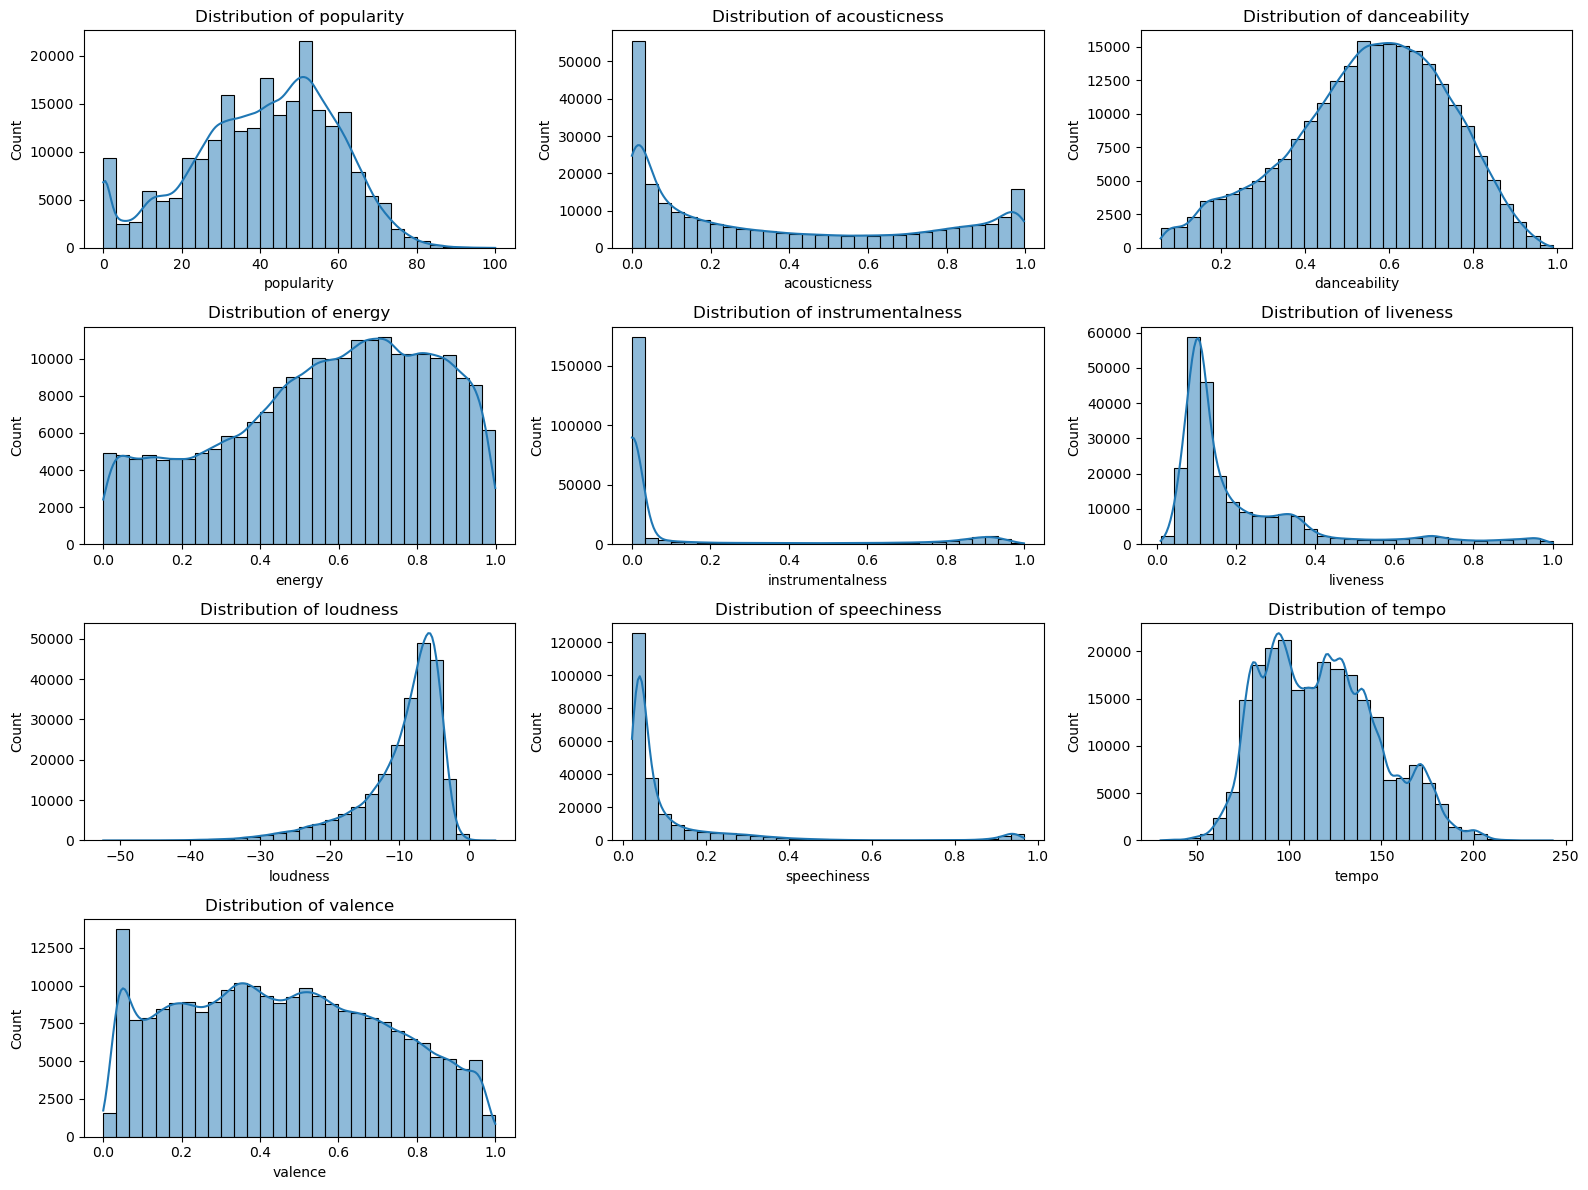

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = [
    'popularity', 'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness',
    'tempo', 'valence'
]

plt.figure(figsize=(16, 12))
for i, col in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [19]:
from sklearn.preprocessing import StandardScaler

# 클러스터링에 사용할 수치형 컬럼 정의
cluster_features = [
    'popularity', 'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness',
    'tempo', 'valence'
]

# 정규화
scaler = StandardScaler()
X_cluster = scaler.fit_transform(data[cluster_features])


In [20]:
from sklearn.cluster import KMeans
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # 원하는 CPU 개수로 설정
# 군집 수 설정 (예: 4개 클러스터)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

# 클러스터 결과를 데이터프레임에 추가
data['cluster_kmeans'] = cluster_labels


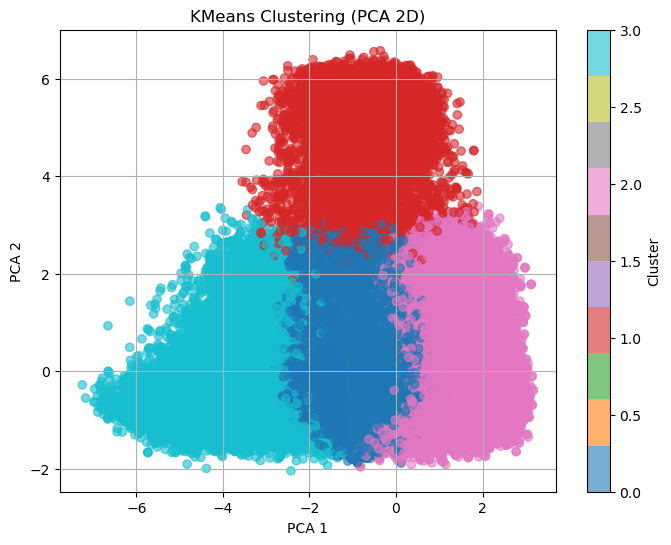

In [21]:
from sklearn.decomposition import PCA

# 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

# 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title("KMeans Clustering (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


In [22]:
# ▶ 수치형 컬럼 (평균용)
cluster_features = [
    'popularity', 'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness',
    'tempo', 'valence'
]

# ▶ 범주형 컬럼 (최빈값용)
categorical_cols = ['genre', 'key', 'mode', 'time_signature']

# 평균 요약
cluster_mean = data.groupby('cluster_kmeans')[cluster_features].mean().round(3)

# 최빈값 요약
cluster_mode = data.groupby('cluster_kmeans')[categorical_cols].agg(lambda x: x.mode()[0])

# ▶ 결과 합치기
cluster_summary = pd.concat([cluster_mean, cluster_mode], axis=1)

# 보기 좋게 출력
import pandas as pd
from IPython.display import display
display(cluster_summary)


,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre,key,mode,time_signature
cluster_kmeans,,,,,,,,,,,,,,
0,40.627,0.571,0.566,0.404,0.099,0.167,-10.650,0.072,113.638,0.406,Folk,C,Major,4/4
1,20.723,0.791,0.562,0.661,0.002,0.729,-12.030,0.872,98.280,0.415,Comedy,C#,Major,4/4
2,46.841,0.118,0.614,0.743,0.063,0.210,-6.129,0.102,124.813,0.555,Reggaeton,C#,Major,4/4
3,25.865,0.862,0.295,0.164,0.617,0.162,-20.406,0.049,102.740,0.160,Soundtrack,C,Major,4/4


| 클러스터 | 대표 장르    | 청취 패턴 특징 |
|----------|---------------|----------------|
| **0**    | Folk          | 🎧 평균적인 인기와 에너지, 적당한 acoustic/dance → 일반적인 음악 청취자 |
| **1**    | Comedy        | 📣 Speechiness 0.87, liveness ↑, energy ↑ → 토크/코미디 위주 콘텐츠 사용자 |
| **2**    | Reggaeton     | 🔊 popularity ↑, danceability ↑, energy ↑ → 클럽/댄스/파티 음악 사용자 |
| **3**    | Soundtrack    | 🎼 instrumentalness 0.61, energy ↓, acousticness ↑ → 연주곡/OST 위주 사용자 |


In [23]:
# 이탈 기준 적용
data['churn'] = (data['popularity'] < 30).astype(int)

# 군집별 이탈률 계산
churn_summary = data.groupby('cluster_kmeans')['churn'].mean().sort_values(ascending=False)

print("📉 클러스터별 이탈률:")
print(churn_summary)


📉 클러스터별 이탈률:
cluster_kmeans
1    0.830711
3    0.545285
0    0.227025
2    0.156209
Name: churn, dtype: float64
